In [1]:
%matplotlib inline
import json,requests
import numpy as np
import pandas as pd
import hashlib
import matplotlib.pyplot as plt
import re
from itertools import compress
import os
import csv
from readDBF import getAreaDict as readArea
import subprocess
import base64
from cryptography.fernet import Fernet
import ast
import getpass
from wand.image import Image as WImage
from readDBF import getAccessToken,getStationsInPolygon,getStationsWithTimeSeries,downloadStations,getArealWeight

#Interacting with data.met.no using their web API
#Getting credentials token  #This should be made private
credentials = bytes('gAAAAABaBG5P2tZrbQdYrW_47s4XFCNt29iSXg_BO2-acCOz--uCGVKoG78UGE5gZnpMexVTvlzbG9oa0kywsEQdb_4Qj_QqSAXPNoGKfb7_JXj0iTW_x5mYHJI8akU0vSLmy51NN59T89cnVBtzeQpCJhZ9VygmvbaJTg3fBJXjIAmzrYZKovQkWrSAM-DpzvhOtYpCsoOl_9EMwPCozYXx5-gt-BGQ35KsqswpVhJQ5GYQPngbF_pTxUDvMZl0YtR2tF300rKMWKUSQBtmMyHGADtNdt_R5g==','utf-8')
key = getpass.getpass('Password: ')
token = getAccessToken(credentials,key)

Password: ········


# HBV modelling at Storelva and Alna

This document describes the setup of the HBV hydrological model for the Storelva and Alna basins for the Elveøvervåkning project.

## Data

### DEM

Freely available [SRTM](https://www2.jpl.nasa.gov/srtm/cbanddataproducts.html) (Shuttle Radar Topgraphy Mission) downloaded through [Earth Explorer](https://earthexplorer.usgs.gov/). The DEM (Digital Elevation Model) has a resolution of 1 arcsecond (around 30m, depending on lat/long).

### Discharge
NVE discharge data from the Hydra II database was used. Øyvind and James provided the data. 

### Meteo data

Meteorological data provided by the [Meteorologisk Institut](https://www.met.no/) was downloaded from data.met.no using their web API.

The relevant stations were identified through the following sequential procedure:

1. Using the DEM and outlet coordinates, define the basin boundaries using the [TauDEM](http://hydrology.usu.edu/taudem/taudem5/index.html) package for [QGIS](http://www.qgis.org/en/site/)
1. Once the basin boundaries are found, apply a buffer of 20km to define a new polygon
1. Simplify this polygon to contain less nodes. 
1. The stations falling inside the simplified polygon are found using the [data.met.no API](https://data.met.no/concepts#getting_started). The polygon was simplified because the API does not allow complex (read: with many nodes) polygons.
1. After finding the stations inside the simplified polygon the data.met.no API is used to obtain the data.

#### Storelva:

**Polygon within which data will be downloaded:**

In [2]:
#Getting the stations inside polygon
bufferPolygon = {"geometry" : "POLYGON ((8.81360824104544 58.3869720294933,8.8125028700531 58.3869720294933,\
                                         8.6791677645676 58.3953610184671,8.60871817835044 58.4078316604784,\
                                         8.544997747267 58.4279695946296,8.50689461648946 58.4463048034402,\
                                         8.50633924999728 58.4465815465334,8.49099380464867 58.4548350829999,\
                                         8.46133251041572 58.4740109742843,8.42766444285739 58.5056030048141,\
                                         8.27138459382926 58.743351075524,8.27089976921798 58.7448863527932,\
                                         8.26061628035923 58.7874474777441,8.26061068868838 58.7880030257529,\
                                         8.27005912028686 58.8306114786912,8.27190783031019 58.8369608761273,\
                                         8.30132417684837 58.877613167147,8.32615860267637 58.8981155181514,\
                                         8.32726606748229 58.8989513172291,8.34880423962018 58.913403348958,\
                                         8.35213441837166 58.9153545233252,8.38250057661261 58.9313842788951,\
                                         8.57056774962507 59.0276499331302,8.57112343069301 59.0279287549333,\
                                         8.57485065403635 59.0296281921703,8.60447108306633 59.0417407707434,\
                                         8.60725346310722 59.0428564804952,8.64764625550636 59.0578781395321,\
                                         8.64931721292992 59.0584361400151,8.68638626836099 59.069210185066,\
                                         8.6875014091089 59.0694892730974,8.76133840228979 59.0829069995879,\
                                         8.83915934393268 59.0874577999235,8.84195176718576 59.0874577999235,\
                                         8.90590200517655 59.0843975582368,8.96765031953956 59.0753235883613,\
                                         8.97043969271922 59.0747653172284,9.03226011451928 59.0585569207396,\
                                         9.04709042306085 59.0534237922437,9.11060349499515 59.0278925193649,\
                                         9.16094471854161 58.9955025904353,9.23350098744031 58.9268477216687,\
                                         9.23515662956912 58.9251770693175,9.24251424734043 58.9174365670571,\
                                         9.24745771522031 58.9121678889074,9.26776855524579 58.8777326347966,\
                                         9.32019757070847 58.7599084953218,9.33087499745802 58.7146706864876,\
                                         9.33756630546066 58.6616158474774,9.337563530116 58.6613380734454,\
                                         9.32725562166499 58.6186433365347,9.32088020021624 58.6063642913696,\
                                         9.29601118290045 58.5677236961361,9.25517172081356 58.5329982135567,\
                                         9.11751578395056 58.4549336058523,9.11251360927467 58.4521656442708,\
                                         9.09976027410873 58.4454684233105,9.09808800348876 58.444635118617,\
                                         9.02806987649948 58.4176736877783,8.94745838810684 58.4007802536512,\
                                         8.93996069903211 58.3996186404481,8.87791549426874 58.390161590337,\
                                         8.81360824104544 58.3869720294933))"}

**Finding out stations within the polygon:**

In [3]:
datesToGet = '2007-01-01/2016-12-31'
idString, stationsDict, coordsDict,insideStations = getStationsInPolygon(token,bufferPolygon,datesToGet)
print(coordsDict.keys())

dict_keys(['RV41 HYNNEKLEIV', 'FROLAND - BLAKSTAD', 'RV41 ÅMLI', 'E18 HASLESTAD', 'HYNNEKLEIV', 'ARENDAL BRANNSTASJON', 'GJERSTAD JERNBANESTASJON', 'VEGÅRDSHEI - MYRA', 'GJERSTAD I AUST-AGDER', 'LYNGØR FYR', 'RISØR', 'TORUNGEN FYR', 'STORGAMA', 'REVESAND', 'RISØR BRANNSTASJON', 'FV76 ØSTERHOLTHEIA', 'NELAUG', 'REIERSØL', 'BØYLEFOSS', 'ARENDAL BRANNSTASJON II', 'EIKELAND', 'ÅMLI', 'ARENDAL LUFTHAVN', 'GJERSTAD', 'TVEDESTRAND'])


**Finding out which of the above stations have mean daily discharge or temperature for a given period**

**The precipitation and temperature are accumulated and averaged respectively at either 0600 or 1800. We use the 0600 measurements for our daily model**

In [4]:
variablesToGet = ['sum(precipitation_amount P1D)','mean(air_temperature P1D)']
stations = getStationsWithTimeSeries(token,idString,datesToGet,variablesToGet)

**Querying data.met.no for the data**

In [5]:
allData = downloadStations(token,stations,stationsDict,datesToGet)   

sum(precipitation_amount P1D) EIKELAND
sum(precipitation_amount P1D) GJERSTAD I AUST-AGDER
sum(precipitation_amount P1D) GJERSTAD JERNBANESTASJON
mean(air_temperature P1D) GJERSTAD JERNBANESTASJON
sum(precipitation_amount P1D) RISØR BRANNSTASJON
sum(precipitation_amount P1D) LYNGØR FYR
mean(air_temperature P1D) LYNGØR FYR
sum(precipitation_amount P1D) ARENDAL BRANNSTASJON
sum(precipitation_amount P1D) ARENDAL BRANNSTASJON II
sum(precipitation_amount P1D) TORUNGEN FYR
mean(air_temperature P1D) TORUNGEN FYR
sum(precipitation_amount P1D) REIERSØL
mean(air_temperature P1D) ARENDAL LUFTHAVN
sum(precipitation_amount P1D) BØYLEFOSS
sum(precipitation_amount P1D) NELAUG
mean(air_temperature P1D) NELAUG
mean(air_temperature P1D) STORGAMA
sum(precipitation_amount P1D) HYNNEKLEIV
mean(air_temperature P1D) HYNNEKLEIV


**Plotting precipitation for all stations inside buffer polygon**

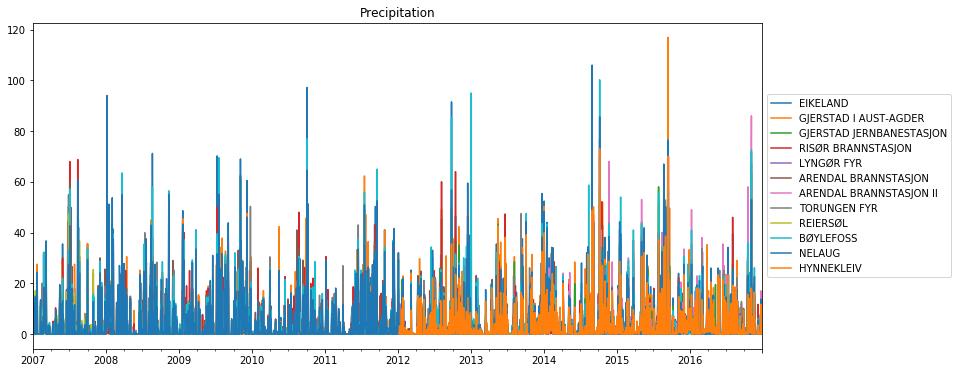

In [6]:
precipitation = pd.read_pickle('precipitation')
f = plt.figure(figsize=(15,6))
plt.title('Precipitation', color='black')
precipitation.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Plotting temperature for all stations inside buffer polygon**

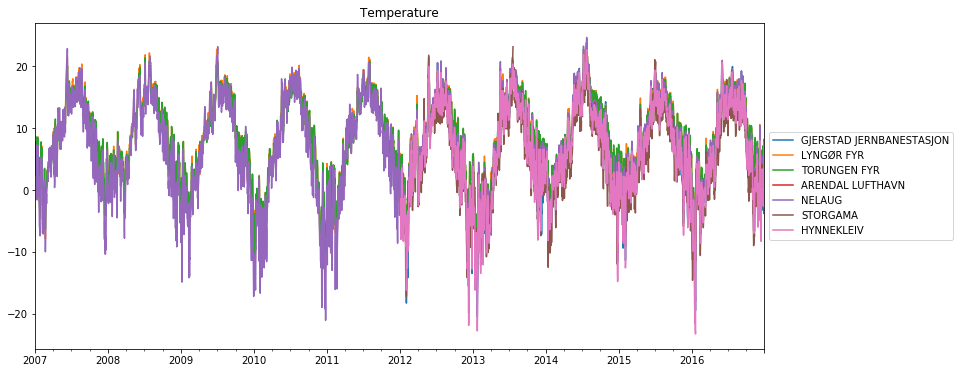

In [7]:
temperature = pd.read_pickle('temperature')
f = plt.figure(figsize=(15,6))
plt.title('Temperature', color='black')
temperature.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Getting areally weighted precipitation for the basin using Thiessen polygons**

In [8]:
basinFile = '/home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Storelva/Processed/Storelva_polygon/Storelva_polygon'
weightDict = getArealWeight(basinFile,1,precipitation,insideStations,coordsDict,4326)

Processing shape: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

**Actual computation of the weighted precipitation**

In [24]:
#Getting weighted precipitation
weighted_precip = []    
for index, row in precipitation.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    totalWeight = sum(weights.values())
    weighted_precip.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )
    

f = plt.figure(figsize=(15,6))
plt.title('Weighted precipitation', color='black')
plt.plot(precipitation.index.to_pydatetime(),weighted_precip)
plt.show()

KeyError: '6ce2e1d63414acd6a8ccdb2a71cd6a3a'

**Generating areally weighted temperature using Thiessen polygons**

In [10]:
weightDict = getArealWeight(basinFile,1,temperature,insideStations,coordsDict,4326)

Processing shape: 
0 1 2 3 

**Actually computing the weighted temperature**

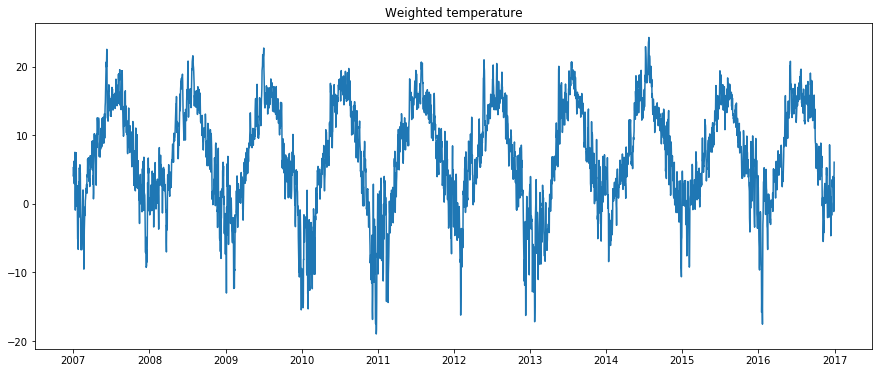

In [11]:
#Getting weighted precipitation
weighted_temp = []    
for index, row in temperature.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    totalWeight = sum(weights.values())
    weighted_temp.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )    

f = plt.figure(figsize=(15,6))
plt.title('Weighted temperature', color='black')
plt.plot(temperature.index.to_pydatetime(),weighted_temp)
plt.show()

#### Alna

The Alna basin could not be accurately delineated using the SRTM data. Instead the 10m DEM provided by [Kartverket](https://kartkatalog.geonorge.no/search) was used. This allowed to better delineate the basin albeit at the cost of slower processing of the geographic data.

**Map of the basin**


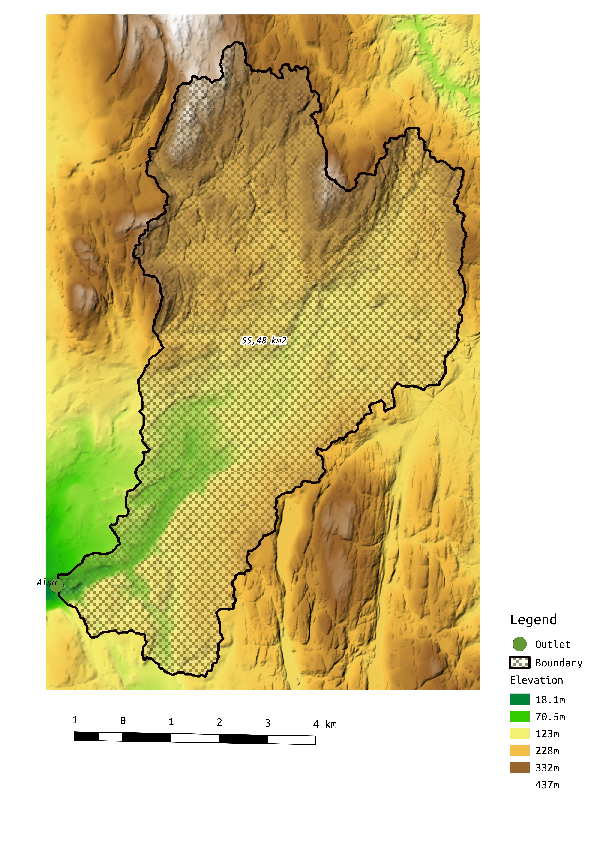

In [12]:
img = WImage(filename='/home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Alna/Processed/map.pdf')
img


**Polygon within which data are downloaded**

In [13]:
bufferPolygon = {"geometry" : "POLYGON ((10.6155136703435 59.9196896865534,10.6815690054444 60.0372740853484,\
                                         10.807001004903 60.0902525583849,10.8913740947938 60.0938074577722,\
                                         10.9744636191411 60.0790820828397,11.0765531530743 60.0419204680413,\
                                         11.1172893192172 60.0077398376955,11.1017233295938 59.9059178329121,\
                                         10.9741873524163 59.8247131318076,10.9132714509575 59.8040171753971,\
                                         10.8052217652737 59.7990497737445,10.6918414017448 59.8252561047246,\
                                         10.6258896617061 59.8706048760629,10.6155136703435 59.9196896865534))"}

**Finding out stations within the polygon**

In [14]:
idString, stationsDict, coordsDict,insideStations = getStationsInPolygon(token,bufferPolygon,datesToGet)
print(coordsDict.keys())

dict_keys(['VALLERUDÅSEN', 'OSLO - BROBEKK', 'OSLO - HØYENHALL', 'OSLO - BESSERUD', 'OSLO - SOLLI PLASS', 'SKULLERUD VRA', 'OSLO - VESTLI', 'RV4 GJELLERÅSEN', 'E6 FURUSET', 'OSLO - HAUSMANNSGT', 'LILLESTRØM', 'OSLO - FURUSET', 'OSLO - LJABRUVEIEN', 'TRYVASSHØGDA', 'LØRENSKOG - HANEBORG', 'OSLO - AMMERUD', 'OSLO - BLINDERN', 'OSLO - TONSENHAGEN', 'OSLO - HAUGENSTUA', 'OSLO - LØREN', 'NITTEDAL - ROTNES', 'RV4 AKER SYKEHUS', 'OSLO - KJELSÅS', 'OSLO - HØYBRÅTEN', 'LØRENSKOG', 'MARIDALSOSET', 'OSLO - ELVEBAKKEN', 'OSLO - KVÆRNERBYEN', 'OSLO - SANDAKER', 'OSLO - TØYEN', 'OSLO - NYLAND', 'E6 DJUPDALEN', 'OSLO - HOVIN', 'OSLO - TRASOP', 'E18 HJORTNES', 'OSLO - BYGDØY', 'OSLO - LILLEAKER', 'OSLO - RYEN', 'OSLO - STUDENTERLUNDEN', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'SKEDSMO - HELLERUD', 'OSLO - SOFIENBERG', 'NORDSTRAND', 'NESODDEN - TANGENÅSEN', 'TRYVANNSHØGDA', 'KJELLER', 'ALNA', 'OSLO - BLINDERN PLU', 'OSLO - LAMBERTSETER', 'OSLO - ØSTENSJØ'])


**Finding out which of the above stations have mean daily discharge or temperature for a given period**

**The precipitation and temperature are accumulated and averaged respectively at either 0600 or 1800. We use the 0600 measurements for our daily model**

In [15]:
variablesToGet = ['sum(precipitation_amount P1D)','mean(air_temperature P1D)']
stations = getStationsWithTimeSeries(token,idString,datesToGet,variablesToGet)

**Querying data.met.no for the data**

In [16]:
allData = downloadStations(token,stations,stationsDict,datesToGet)     

sum(precipitation_amount P1D) VALLERUDÅSEN
sum(precipitation_amount P1D) LØRENSKOG - HANEBORG
mean(air_temperature P1D) KJELLER
sum(precipitation_amount P1D) SKEDSMO - HELLERUD
mean(air_temperature P1D) SKEDSMO - HELLERUD
sum(precipitation_amount P1D) NESODDEN - TANGENÅSEN
sum(precipitation_amount P1D) OSLO - LJABRUVEIEN
mean(air_temperature P1D) OSLO - LJABRUVEIEN
sum(precipitation_amount P1D) OSLO - LAMBERTSETER
mean(air_temperature P1D) OSLO - LAMBERTSETER
sum(precipitation_amount P1D) SKULLERUD VRA
sum(precipitation_amount P1D) NORDSTRAND
sum(precipitation_amount P1D) OSLO - KVÆRNERBYEN
sum(precipitation_amount P1D) OSLO - RYEN
sum(precipitation_amount P1D) OSLO - ØSTENSJØ
sum(precipitation_amount P1D) OSLO - TRASOP
sum(precipitation_amount P1D) OSLO - HØYENHALL
sum(precipitation_amount P1D) OSLO - LØREN
sum(precipitation_amount P1D) OSLO - HOVIN
mean(air_temperature P1D) OSLO - HOVIN
sum(precipitation_amount P1D) OSLO - BROBEKK
sum(precipitation_amount P1D) OSLO - TONSENHAGEN
mean

**Plotting precipitation for all stations inside buffer polygon**

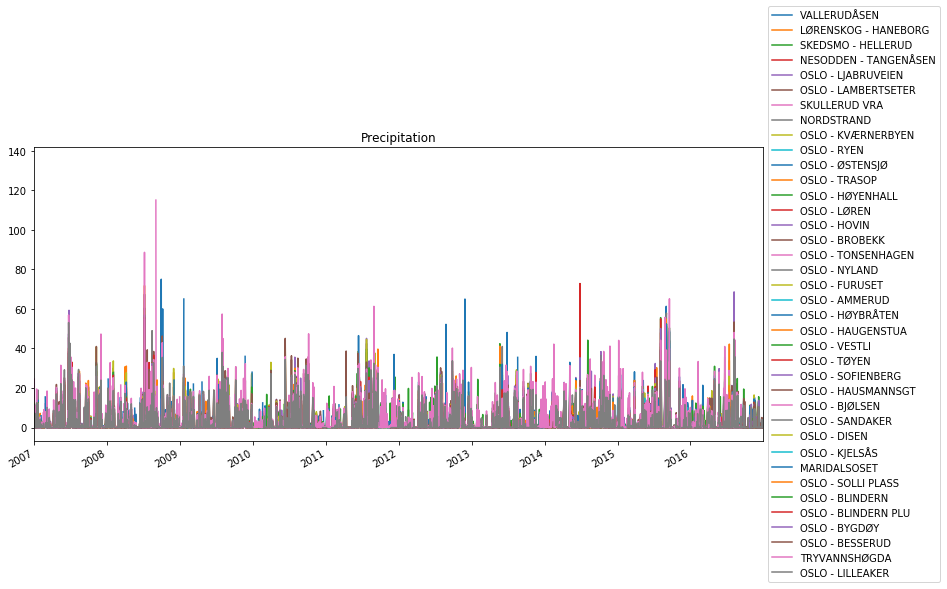

In [17]:
precipitation = pd.read_pickle('precipitation')
f = plt.figure(figsize=(15,6))
plt.title('Precipitation', color='black')
precipitation.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Plotting temperature for all stations inside buffer polygon**

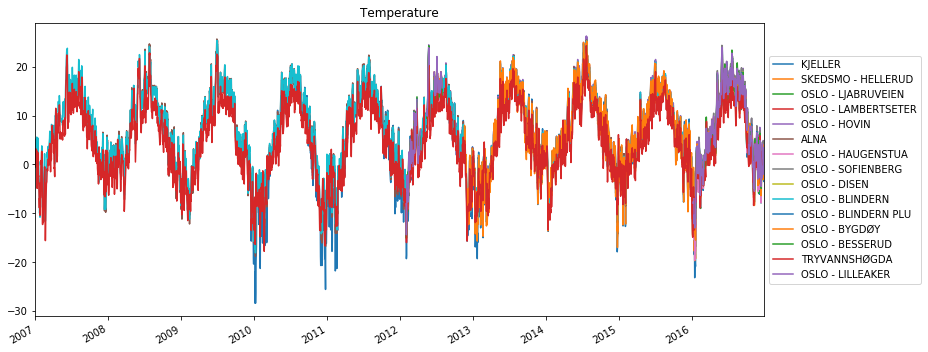

In [18]:
temperature = pd.read_pickle('temperature')
f = plt.figure(figsize=(15,6))
plt.title('Temperature', color='black')
temperature.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Generating areally weighted precipitation using Thiessen polygons**

In [19]:
basinFile = '/home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Alna/Processed/Alna_basin'
weightDict = getArealWeight(basinFile,5000,precipitation,insideStations,coordsDict,32632)

Processing shape: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272

**Actually computing and plotting weighted precipitation**

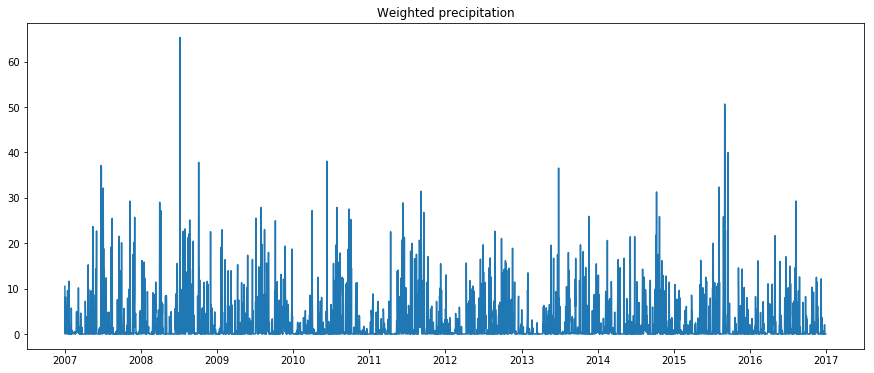

In [20]:
#Getting weighted precipitation
totalWeight = sum(list(weightDict[list(weightDict.keys())[0]].values()))
weighted_precip = []    
for index, row in precipitation.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    weighted_precip.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )    

f = plt.figure(figsize=(15,6))
plt.title('Weighted precipitation', color='black')
plt.plot(precipitation.index.to_pydatetime(),weighted_precip)
plt.show()

**Generating areally weighted temperature using Thiessen polygons**

In [23]:
weightDict = getArealWeight(basinFile,5000,temperature,insideStations,coordsDict,32632)

Processing shape: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

**Actually computing and plotting weighted temperature**

In [ ]:
#Getting weighted temperature
totalWeight = sum(list(weightDict[list(weightDict.keys())[0]].values()))
weighted_temp = []    
for index, row in temperature.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    weighted_temp.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )   

f = plt.figure(figsize=(15,6))
plt.title('Weighted temperature', color='black')
plt.plot(temperature.index.to_pydatetime(),weighted_temp)
plt.show()